In [1]:
%load_ext autoreload
%autoreload 2
import torch
import math
import random
%matplotlib inline
relPath = "../../"
import sys
sys.path.append(relPath)
from mm.printing import *
from mm.neural.neural import *
from layers import *
from network import *
from neural import *

In [2]:
initLogging("Common init")

dvc = torch.device("cpu")
log("device", dvc.type)

Common init:             -------------------------- 2023-07-27 16:53:07
device:                  cpu


In [3]:
logSection("Prepare data")

filePath = relPath + "data/names.txt"
log("filePath", filePath)

ldr = loadData(filePath)
printDataInfo(ldr)

Prepare data:            -------------------------- 2023-07-27 16:53:07
filePath:                ../../data/names.txt
First few words:         ['emma', 'olivia', 'ava', 'isabella', 'sophia']
Words counts:            32033
Vocabulary:              ['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
stoi:                    {'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
itos:                    {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
Vocabulary + end length: 27
random probability:      3.2958


In [4]:
logSection("Prepare dataset")

wordShufflingSeed = 42
log("Words shuffling seed", wordShufflingSeed)
random.seed(wordShufflingSeed)
random.shuffle(ldr.words)

contextSize = 3
log("Context size", contextSize)

ds = buildDataSet(ldr, contextSize, 0.8, 0.9, torch.int64, dvc)

Prepare dataset:         -------------------------- 2023-07-27 16:53:07
Words shuffling seed:    42
Context size:            3
Data dtype:              torch.int64
Training ratio:          0.8
Validation ratio:        0.9
Training:                length 25626 shape [182625, 3] ['yuheng', 'diondre', 'xavien']
Validation:              length 3203 shape [22655, 3] ['amay', 'aytana', 'jenevi']
Test:                    length 3204 shape [22866, 3] ['mustafa', 'reuben', 'kahlel']


In [5]:
logSection("Build network")

embeddingDims = 10
log("Embedding dimensions", embeddingDims)

hiddenLayerSize = 100
log("Hidden layers size", hiddenLayerSize)

learningSeed = 2147483647
log("Learning seed", learningSeed)
g = torch.Generator(device=dvc).manual_seed(learningSeed)

dtype = torch.float
log("dtype", dtype)

np = makeNetwork2(g, len(ldr.stoi), embeddingDims, contextSize, hiddenLayerSize, dtype, dvc)
printNetworkInfo(np)
    
@torch.no_grad()
def trLoss(): return getLoss(np, np.C[ds.tr.x], ds.tr.y)

@torch.no_grad()
def valLoss(): return getLoss(np, np.C[ds.val.x], ds.val.y)

@torch.no_grad()
def tstLoss(): return getLoss(np, np.C[ds.tst.x], ds.tst.y)

def getLosses() -> Losses:
    l = Losses()
    l.tr = trLoss()
    l.val = valLoss()
    l.tst = tstLoss()
    return l

def logLosses():
    losses = getLosses()
    l1 = f"{losses.tr.loss.item():>10.4f}"
    l2 = f"{losses.val.loss.item():>10.4f}"
    l3 = f"{losses.tst.loss.item():>10.4f}"
    logSimple(f"{l1} {l2} {l3}")

Build network:           -------------------------- 2023-07-27 16:53:08
Embedding dimensions:    10
Hidden layers size:      100
Learning seed:           2147483647
dtype:                   torch.float32
Network Layers Structure:
  LinearWithBias 1:      [30, 100], [100]
  Tanh 2:                
  LinearWithBias 3:      [100, 100], [100]
  Tanh 4:                
  LinearWithBias 5:      [100, 100], [100]
  Tanh 6:                
  LinearWithBias 7:      [100, 100], [100]
  Tanh 8:                
  LinearWithBias 9:      [100, 100], [100]
  Tanh 10:               
  LinearWithBias 11:     [100, 27], [27]
Parameters Count:        46497


Activations distribution - Linear
  LinearWithBias 1:      mean: +0.00362, std: +0.18726, saturated: 0.00%
  LinearWithBias 3:      mean: -0.00055, std: +0.09968, saturated: 0.00%
  LinearWithBias 5:      mean: +0.00051, std: +0.10068, saturated: 0.00%
  LinearWithBias 7:      mean: +0.00206, std: +0.10034, saturated: 0.00%
  LinearWithBias 9:      mean: -0.00048, std: +0.10035, saturated: 0.00%
  LinearWithBias 11:     mean: +0.00052, std: +0.09887, saturated: 0.00%
Plot:                    01 Activations distribution - Linear (16_53_08).png


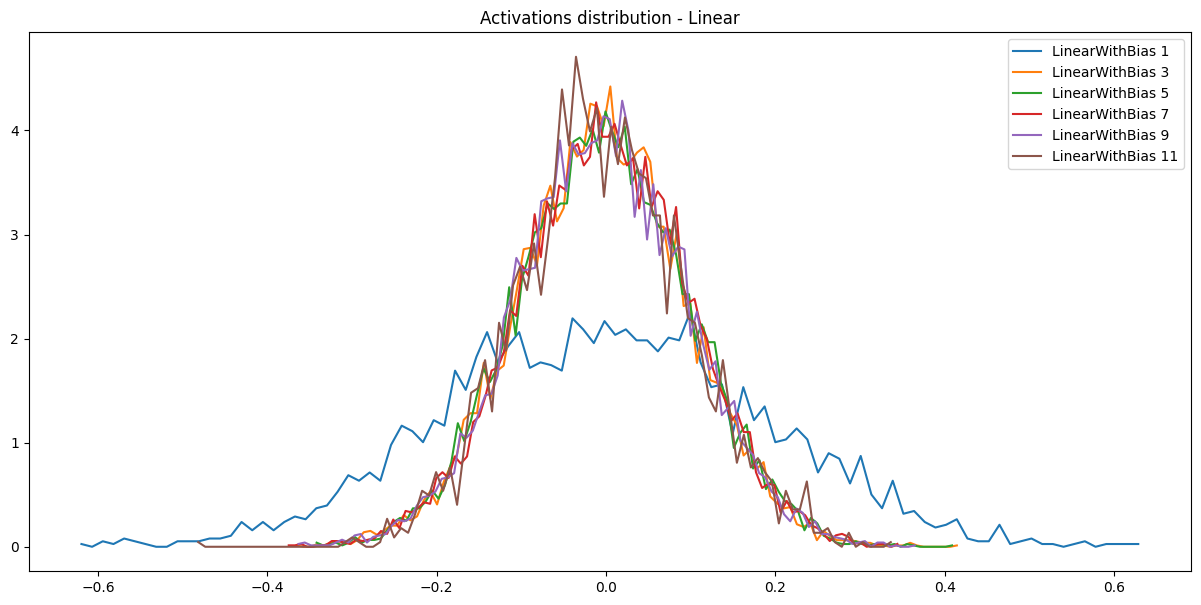

In [6]:
plotActivationsDistribution(Linear, np.layers)
#plotActivationsDistribution(LinearWithBias, np.layers)

In [7]:
logSection("Training")

trainingBatchSize = 32
log("Training batch size", trainingBatchSize)

trXLength = ds.tr.x.shape[0]
trainingSteps = (trXLength // trainingBatchSize) + 1
log ("Training steps: ", trainingSteps)

repeats = 36
log("Repeats", repeats)

maxIteration = 1000
log("Max iterations", maxIteration)

maxLr = 0.05
log("Max learning rate", maxLr)

minLr = 0.01
log("Min learning rate", minLr)

actualIterations = min(maxIteration, repeats * math.ceil(trXLength / trainingBatchSize))
log("Actual iterations", actualIterations)

for l in np.layers:
    if isinstance(l, BatchNorm1d):
        l.training = True;

lrAtIx: list[float] = []
stepIx: list[int] = []
lossAtIx: list[float] = []
logLossAtIx: list[float] = []
ud: list[list[float]] = []
up = UpdateNetResult()
fr = ForwardPassResult()
fr.loss = torch.tensor(0)
stopped = False
i = 0
for repeat in range(repeats):
    
    if stopped:
        break;

    logSimple(f"{repeat:>3}, {i:>7} losses: {fr.loss.item():>10.4f}   ", end="")
    logLosses()

    for start in range(0, trXLength, trainingBatchSize):

        if i >= maxIteration:
            stopped = True
            log("Stopped at max iteration")
            break;
        
        end = min(start + trainingBatchSize, trXLength)
        miniBatchIxs = torch.randint(0, trXLength, (trainingBatchSize,), generator=g, device=dvc)
        fr = forwardPass(np, ds.tr.x, ds.tr.y, miniBatchIxs)
        backwardPass(np.layers, np.parameters, fr.loss)
        up = updateNet(np.parameters, i, actualIterations, maxLr, minLr)
        
        if i == 0 or i % 100:
            lrAtIx.append(up.learningRate)
            stepIx.append(i)
            lossAtIx.append(fr.loss.item())
            logLossAtIx.append(fr.loss.log10().item())
            with torch.no_grad():
                vals = [((up.learningRate * not_null(p.grad)).std() / p.data.std()).log10().item() for p in np.parameters]
                ud.append(vals)

        i += 1

logSimple(f"Final losses: {fr.loss.item():>17.4f}   ", end="")
logLosses()

log("Embedding shape", fr.emb.shape)
log("Logits shape", fr.logits.shape)

for l in np.layers:
    if isinstance(l, BatchNorm1d):
        l.training = False;

Training:                -------------------------- 2023-07-27 16:53:09
Training batch size:     32
Training steps: :        5708
Repeats:                 36
Max iterations:          1000
Max learning rate:       0.05
Min learning rate:       0.01
Actual iterations:       1000
  0,       0 losses:     0.0000       3.3078     3.3081     3.3084
Stopped at max iteration:
Final losses:            2.3990       2.4221     2.4190     2.4182
Embedding shape:         [32, 3, 10]
Logits shape:            [32, 27]


In [8]:
logSection("Introspection")

Introspection:           -------------------------- 2023-07-27 16:53:13


Max learning rate:       0.05
Min learning rate:       0.01004
Plot:                    02 Learning rate progress (16_53_13).png


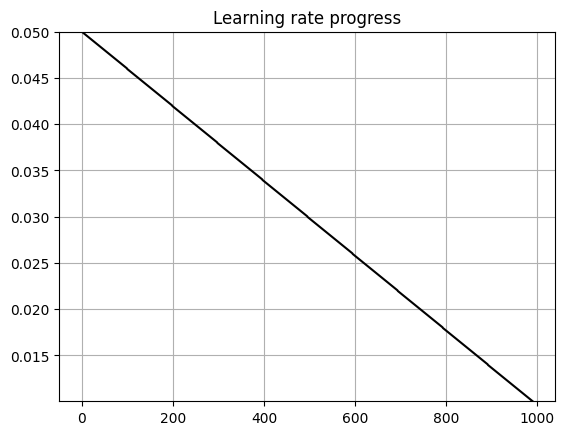

In [9]:
plotLearningRate(lrAtIx)

Activations distribution - Linear
  LinearWithBias 1:      mean: +0.07067, std: +0.89688, saturated: 27.50%
  LinearWithBias 3:      mean: +0.00041, std: +1.00642, saturated: 33.99%
  LinearWithBias 5:      mean: +0.04548, std: +0.98084, saturated: 33.23%
  LinearWithBias 7:      mean: -0.03819, std: +1.06554, saturated: 37.12%
  LinearWithBias 9:      mean: -0.02626, std: +1.18611, saturated: 43.22%
  LinearWithBias 11:     mean: +0.00484, std: +1.34899, saturated: 50.24%
Plot:                    03 Activations distribution - Linear (16_53_14).png


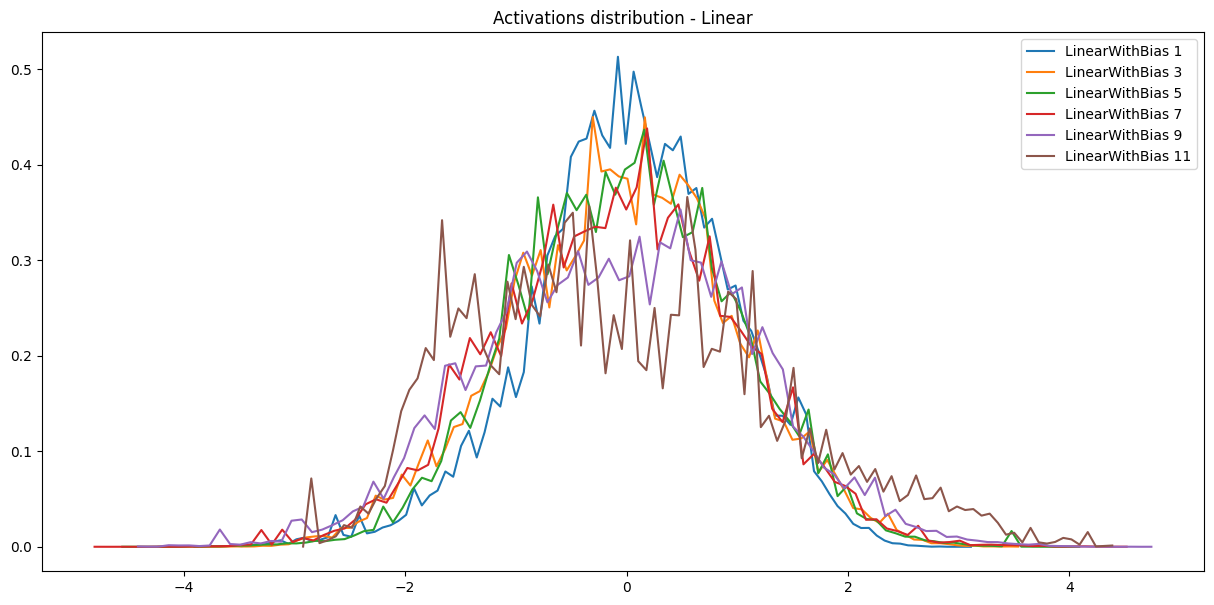

In [10]:
plotActivationsDistribution(Linear, np.layers)

Activations distribution - BatchNorm1d
Plot:                    04 Activations distribution - BatchNorm1d (16_53_14).png


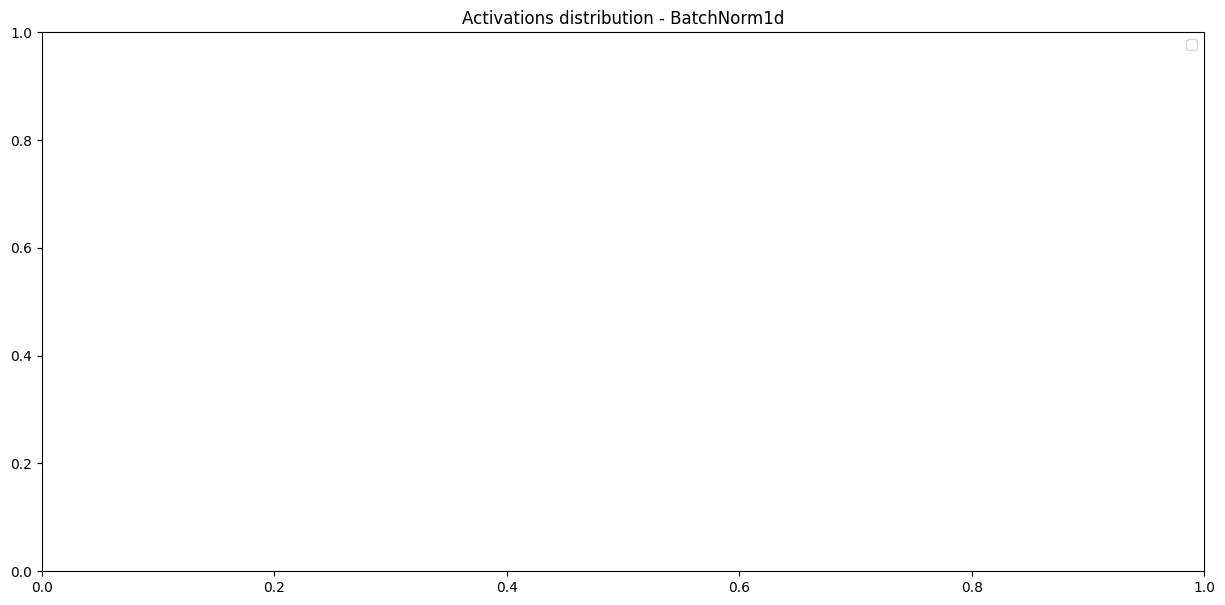

In [11]:
plotActivationsDistribution(BatchNorm1d, np.layers)

Activations distribution - Tanh
  Tanh 2:                mean: +0.05798, std: +0.58845, saturated: 2.09%
  Tanh 4:                mean: +0.00631, std: +0.63257, saturated: 3.71%
  Tanh 6:                mean: +0.02527, std: +0.62563, saturated: 2.85%
  Tanh 8:                mean: -0.01755, std: +0.65056, saturated: 4.55%
  Tanh 10:               mean: -0.00840, std: +0.68808, saturated: 7.07%
Plot:                    05 Activations distribution - Tanh (16_53_15).png


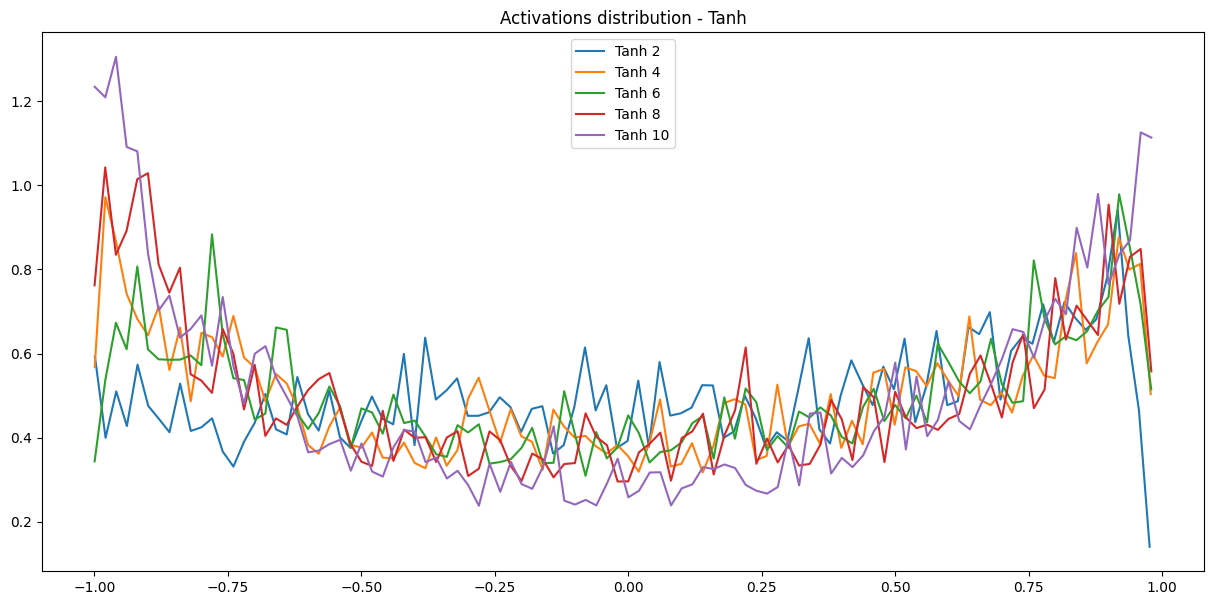

In [12]:
# for use without batch norm (lin with bias) std should be ~0.5 and sat ~5% 
plotActivationsDistribution(Tanh, np.layers)

In [14]:
#lotActivationsDistribution(Linear, np.layers, useGrad=True)
#lotActivationsDistribution(LinearWithBias, np.layers, useGrad=True)
#plotActivationsDistribution(BatchNorm1d, np.layers, useGrad=True)
#lotActivationsDistribution(Tanh, np.layers, useGrad=True)

Gradients weights distribution
  C
    Weight:                [27, 10], mean: -0.00040, std: 1.830620e-02, data ratio: 6.374911e-02
  LinearWithBias 1
    Weight:               [30, 100], mean: +0.00047, std: 1.016064e-02, data ratio: 3.252114e-02
    Weight:                   [100], mean: +0.00111, std: 1.750167e-02, data ratio: 1.431420e+00
  LinearWithBias 3
    Weight:              [100, 100], mean: -0.00021, std: 7.873439e-03, data ratio: 4.730727e-02
    Weight:                   [100], mean: -0.00286, std: 1.294124e-02, data ratio: 1.728403e+00
  LinearWithBias 5
    Weight:              [100, 100], mean: -0.00000, std: 6.960724e-03, data ratio: 4.139718e-02
    Weight:                   [100], mean: -0.00108, std: 1.198875e-02, data ratio: 2.194392e+00
  LinearWithBias 7
    Weight:              [100, 100], mean: -0.00000, std: 4.734553e-03, data ratio: 2.824933e-02
    Weight:                   [100], mean: +0.00040, std: 7.767159e-03, data ratio: 1.523839e+00
  LinearWithBias

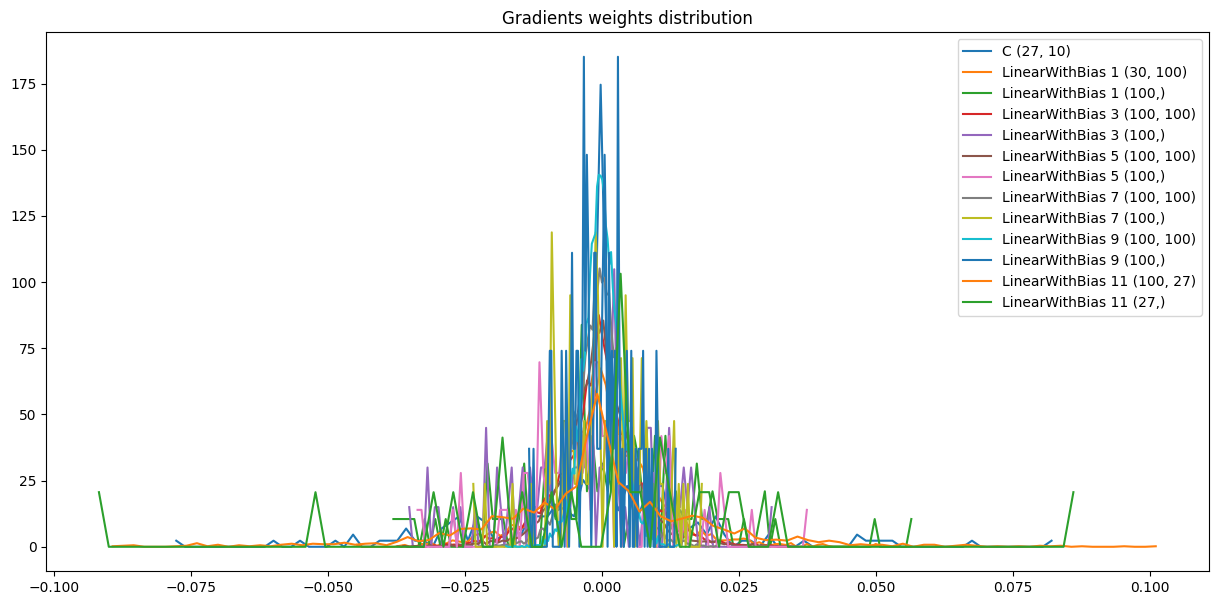

In [15]:
plotGradWeightsDistribution(Linear, np.C, np.layers)
#plotGradWeightsDistribution(np.C, LinearWithBias, np.layers)

Plot:                    07 Gradient update - Data ratio (16_53_39).png


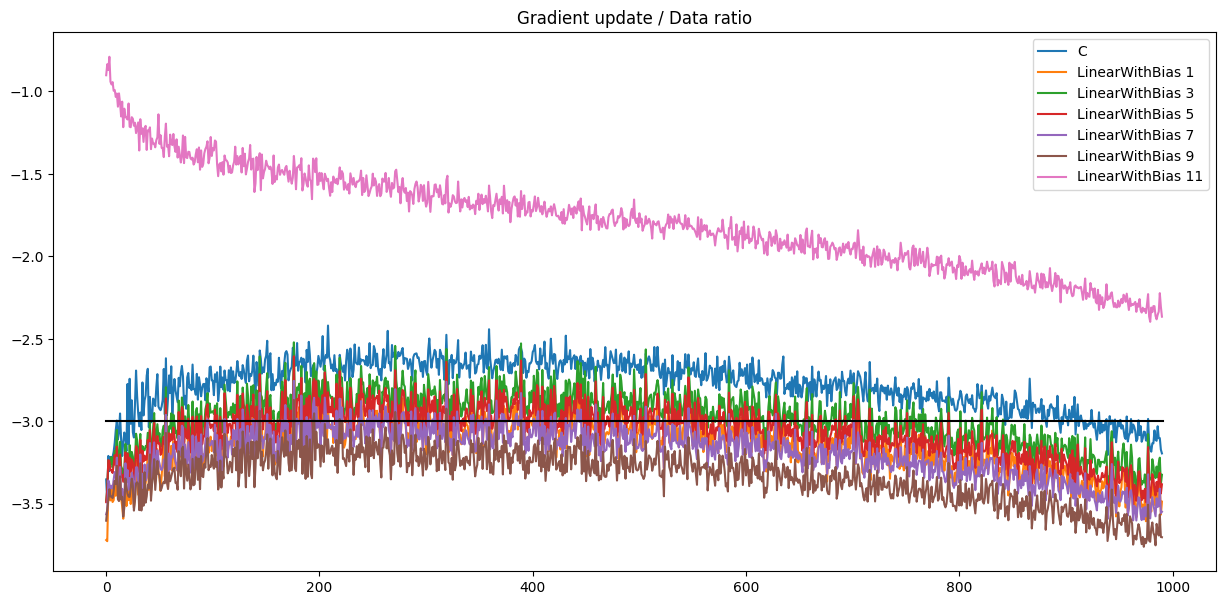

In [16]:
plotGradientUpdateRatio(ud, np.parameters, np.paramNames)

Plot:                    08 Learning rate vs batch loss (16_53_40).png


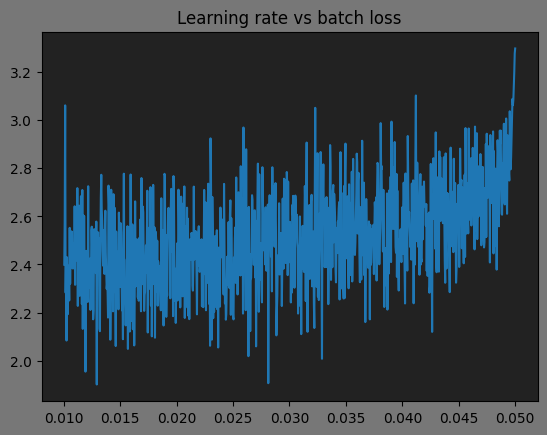

In [17]:
plotXY(lrAtIx, lossAtIx, "Learning rate vs batch loss")

Plot:                    09 Learning batch loss at training step (16_53_40).png


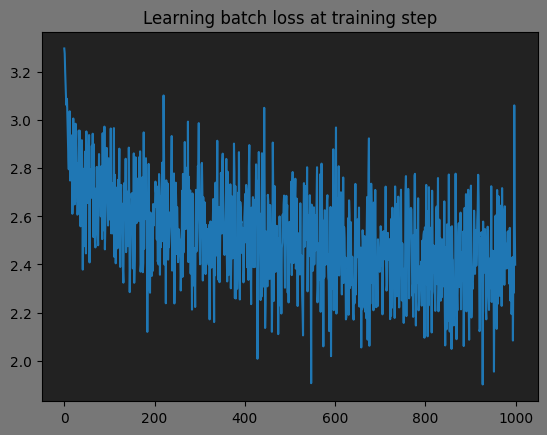

In [18]:
plotXY(stepIx, lossAtIx, "Learning batch loss at training step")

Plot:                    10 Learning batch log-loss at training step (16_53_41).png


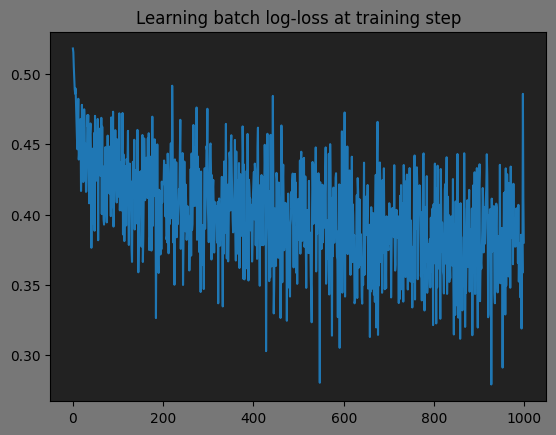

In [19]:
plotXY(stepIx, logLossAtIx, "Learning batch log-loss at training step")

Plot:                    11 Embedding at [0, 1] (16_53_41).png


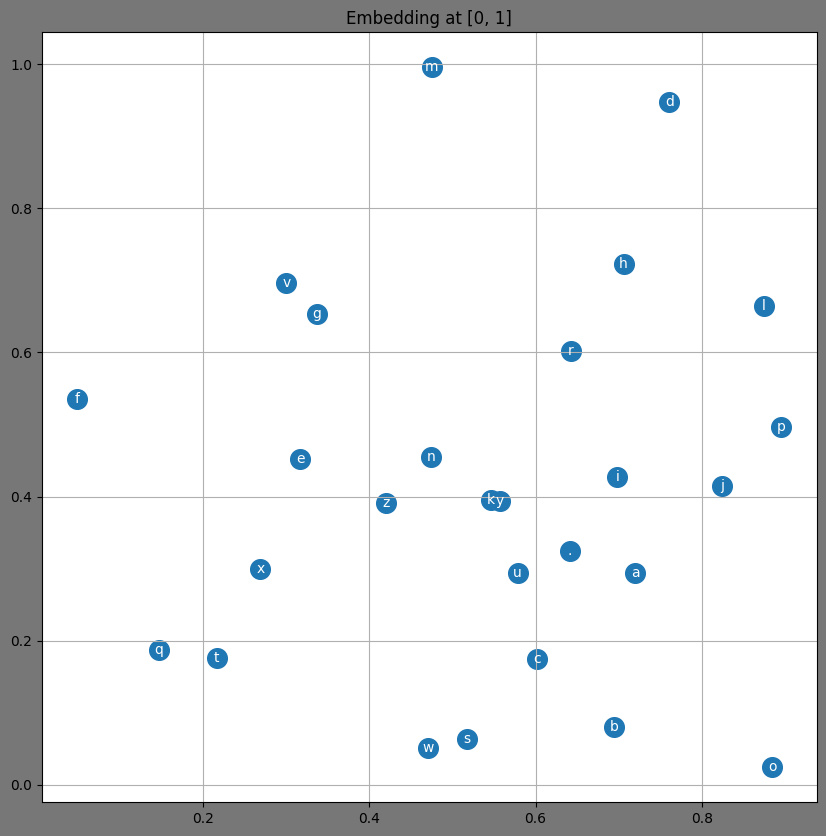

In [20]:
plotEmb(np.C, ldr.itos, 0)

In [21]:
logSection("Sampling")

samplingSeed = learningSeed + 10
gSampling = torch.Generator(device=dvc).manual_seed(samplingSeed)
log("samplingSeed", samplingSeed)

maxSampleLength = 50
log("maxSampleLength", maxSampleLength)

Sampling:                -------------------------- 2023-07-27 16:53:42
samplingSeed:            2147483657
maxSampleLength:         50


In [22]:
samples = sampleMany(np, gSampling, contextSize, ldr.itos, 20, maxSampleLength)
for s in samples:
    logSimple(f"{''.join(s.values):<21}{(s.prob * 10000):>4.0f}: ", end="")
    for p in s.probs:
        logSimple(f"{(p / (1 / 27) * 10):.0f} ", end="")
    logSimple()

mria.                 126: 20 5 58 37 77 
mmyan.                 78: 20 1 21 16 48 137 
seelen.               140: 18 32 15 55 43 56 140 
hayala.                65: 9 122 19 34 15 43 62 
ethasiendrlen.         44: 12 7 12 72 12 59 38 30 3 5 8 68 59 140 
azeredieliiheli.      106: 33 6 32 19 41 5 55 29 17 43 6 6 31 29 61 26 
jelledeinean.         110: 23 42 52 23 61 6 47 12 45 29 14 35 90 
aareely.              177: 33 7 53 36 30 39 26 51 
korlara.              143: 23 31 79 17 43 15 47 57 
noshdbergihirie.       15: 8 36 13 25 2 1 44 9 1 45 2 14 16 44 26 124 
tin.                  117: 13 41 17 113 
jewellelanteucanu.     67: 23 42 2 34 34 29 61 25 41 70 11 60 1 2 37 37 2 71 
zeyedir.               28: 7 39 14 21 4 66 10 53 
yahle.                 27: 5 70 31 5 60 34 
ehs.                   43: 12 8 5 42 
kay.                  189: 23 106 23 21 
mystoyda.              65: 20 11 15 12 22 9 8 43 76 
hil.                   52: 9 21 32 15 
salyansu.              86: 18 80 29 22 47 57 7 3 1

In [23]:
logSection("Probabilities")

def printProb(txt: str):
    ps = calcProb(np, txt, contextSize, ldr.stoi)
    op = calcOneProb(ps)
    logSimple(f"{txt:<25}{(op * 10000):<7.0f}: ", end="")
    for p in ps:
        logSimple(f"{(p / (1 / 27) * 10):.0f} ", end="")
    logSimple()

printProb('.')
printProb('m.')
printProb('mi.')
printProb('mic.')
printProb('mich.')
printProb('micha.')
printProb('michal.')
printProb('michael.')
printProb('michaela.')
printProb('michaella.')
printProb('michel.')
printProb('carol.')
printProb('karol.')
printProb('karel.')
printProb('martin.')
printProb('andrej.')
printProb('andrey.')
printProb('andrew.')
printProb('joey.')
printProb('james.')
printProb('xin.')
printProb('maxim.')
printProb('alex.')
printProb('alexa.')
printProb('x.')
printProb('xx.')
printProb('xxx.')
printProb('xxxx.')

Probabilities:           -------------------------- 2023-07-27 16:53:42
.                        15     : 0 
m.                       52     : 20 1 
mi.                      75     : 20 37 2 
mic.                     104    : 20 37 9 25 
mich.                    131    : 20 37 9 34 93 
micha.                   111    : 20 37 9 34 70 24 
michal.                  100    : 20 37 9 34 70 30 16 
michael.                 86     : 20 37 9 34 70 6 47 20 
michaela.                101    : 20 37 9 34 70 6 47 33 82 
michaella.               98     : 20 37 9 34 70 6 47 16 66 70 
michel.                  100    : 20 37 9 34 25 51 27 
carol.                   57     : 11 89 43 15 14 15 
karol.                   126    : 23 106 42 18 14 15 
karel.                   184    : 23 106 42 32 37 30 
martin.                  161    : 20 116 54 6 62 41 113 
andrej.                  88     : 33 17 25 8 47 1 21 
andrey.                  149    : 33 17 25 8 47 13 87 
andrew.                  98     : 33 17 25 8